## Header import

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import autosklearn.classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import seaborn as sns


## Data Read

In [2]:
# Input the data path
data_path = "data.csv"

# Store the data from csv to dataframe
alldata_df = pd.read_csv(data_path)
alldata_df

,timestamp,part_id,temperature_1,temperature_2,temperature_3,temperature_4,label
0,2024-02-15 05:44:34+05:30,2124077390649042,439.1,424.1,536.0,518.6,0
1,2024-02-15 05:44:35+05:30,2124077390649042,438.9,423.9,535.9,518.7,0
2,2024-02-15 05:44:36+05:30,2124077390649042,438.7,423.6,535.6,518.9,0
3,2024-02-15 05:44:37+05:30,2124077390649042,438.4,423.4,535.4,519.0,0
4,2024-02-15 05:44:38+05:30,2124077390649042,438.2,423.2,535.2,519.2,0
...,...,...,...,...,...,...,...
99995,2024-02-18 04:13:14+05:30,2124087523419042,479.6,460.8,571.1,532.7,0
99996,2024-02-18 04:13:15+05:30,2124087523419042,479.8,460.7,571.2,533.0,0
99997,2024-02-18 04:13:16+05:30,2124087523419042,480.2,460.6,571.2,533.2,0
99998,2024-02-18 04:13:17+05:30,2124087523419042,480.4,460.4,571.3,533.4,0


## Exploratary Data Analysis

### Check - Data Completeness / Missing Values

In [3]:
# Display basic information about the data
print("Dataset Info:")
print(alldata_df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   timestamp      100000 non-null  object 
 1   part_id        100000 non-null  int64  
 2   temperature_1  100000 non-null  float64
 3   temperature_2  100000 non-null  float64
 4   temperature_3  100000 non-null  float64
 5   temperature_4  100000 non-null  float64
 6   label          100000 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 5.3+ MB
None


In [4]:
# This is another way to verify for missing values
if alldata_df.isnull().values.any():
    print("There are null values in the dataset.")
else:
    print("No null values in the dataset.")

No null values in the dataset.


### Check - Outliers

In [5]:
# Basic statistics of numerical columns
print("\nBasic Statistics:")
print(alldata_df.describe())


Basic Statistics:
            part_id  temperature_1  temperature_2  temperature_3  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   2.124078e+15     455.534524     440.114258     546.868253   
std    2.901028e+09      20.596332      23.310541      24.818341   
min    2.124077e+15     350.800000     329.600000     407.700000   
25%    2.124077e+15     440.600000     425.200000     532.600000   
50%    2.124077e+15     454.000000     441.300000     550.000000   
75%    2.124077e+15     472.600000     459.500000     567.200000   
max    2.124088e+15     501.200000     481.000000     582.700000   

       temperature_4          label  
count  100000.000000  100000.000000  
mean      517.654658       0.059700  
std        17.513545       0.236931  
min       435.600000       0.000000  
25%       508.500000       0.000000  
50%       518.300000       0.000000  
75%       530.200000       0.000000  
max       555.400000       1.000000  


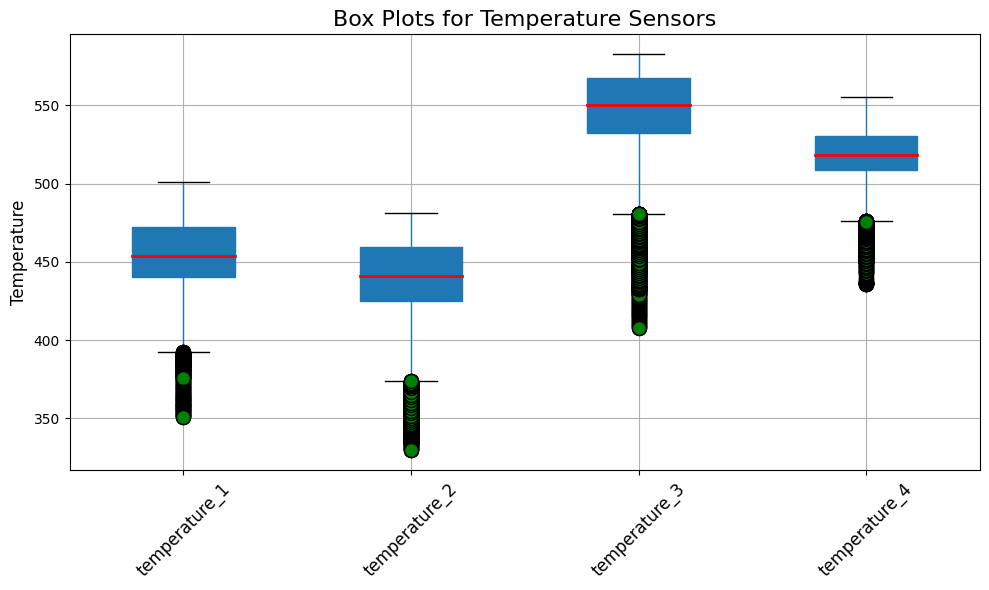

In [6]:
# List the data column for plot
temperature_columns = ['temperature_1', 'temperature_2', 'temperature_3', 'temperature_4']

# Plotting box plots to visualize outliers
plt.figure(figsize=(10, 6))

# Create a box plot for each temperature column
alldata_df[temperature_columns].boxplot(grid=True, vert=True, patch_artist=True, 
                                  medianprops={'color' : 'red', 'linewidth': 2}, 
                                  flierprops={'marker': 'o', 'markerfacecolor': 'g', 'markersize': 10})

# Title and labels
plt.title("Box Plots for Temperature Sensors", fontsize=16)
plt.ylabel('Temperature', fontsize=12)
plt.xticks([1, 2, 3, 4], temperature_columns, rotation=45, fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
# Identify outliers below the lower bound using Interquartile range
outliers_summary = {}
for col in temperature_columns:
    Q1 = alldata_df[col].quantile(0.25)
    Q3 = alldata_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    
    # Find outliers below the lower bound
    outliers = alldata_df[alldata_df[col] < lower_bound]
    outliers_summary[col] = len(outliers)

# Display the number of outliers for each column
print("Number of outliers below the lower bound for each temperature column:")
print(outliers_summary)

# Check the skewness of each column
print("\nSkewness of each temperature column:")
print(alldata_df[temperature_columns].skew())


Number of outliers below the lower bound for each temperature column:
{'temperature_1': 503, 'temperature_2': 978, 'temperature_3': 1845, 'temperature_4': 2435}

Skewness of each temperature column:
temperature_1   -0.280931
temperature_2   -0.735597
temperature_3   -1.121385
temperature_4   -0.677178
dtype: float64


### Check - Class imbalance 

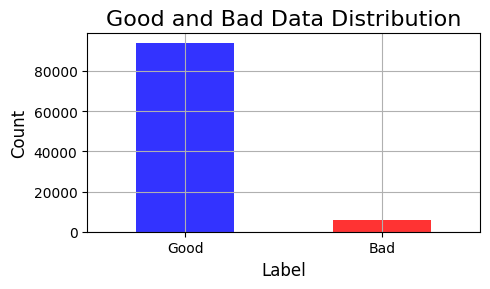

In [8]:
# Visualizing the label distribution
plt.figure(figsize=(5, 3))
alldata_df['label'].value_counts().sort_index().plot(
    kind='bar', color=["blue", "red"], alpha=0.8
)

# Adding title and labels
plt.title('Good and Bad Data Distribution', fontsize=16)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(np.arange(2), ('Good', 'Bad'), rotation=0)

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()

In [9]:
outlier_removed_df = alldata_df[(alldata_df[temperature_columns].apply(zscore).abs() < 3).all(axis=1)]

The outlier removal process is performed using the Z-score method, and the identified outliers are stored separately. This allows for a comparative analysis to assess whether removing the outliers significantly improves the model's performance in this scenario.

## Feature Engineering and Windowing

In [10]:
# Function to extract feature along with windowing
def feature_extraction(df):

    """
        Extracts windowed features from a dataframe grouped by a unique identifier (e.g., `part_id`). 
        The function creates overlapping windows of a specified size and calculates statistical features 
        (max, min, std) for temperature sensors within each window. 
        
        Additionally, it includes the start and end timestamps for each window and associates the label 
        of the last entry in the window as the output label.
        
        Parameters:
        -----------
        df : pandas.DataFrame
            Input dataframe containing sensor data and labels. The dataframe is expected to have the 
            following columns:
            - 'part_id' (identifier for grouping)
            - 'timestamp' (time ordering column)
            - 'temperature_1', 'temperature_2', 'temperature_3', 'temperature_4' (sensor readings)
            - 'label' (target variable)
        
        Returns:
        --------
        tuple
            A tuple containing:
            - pandas.DataFrame: A dataframe with extracted features for each window.
            - pandas.Series: A series containing the labels corresponding to each window.
        """

    grouped = df.groupby('part_id')
    
    # Define window size (you can adjust 'k' as needed)
    window_size = 5  # I have taken 5 in this case
    
    # List to hold feature data for each window
    window_features = []
    
    # Loop through each group (each part_id)
    for part_id, group in grouped:
        # Ensure the data is sorted by timestamp or any other appropriate order
        group = group.sort_values('timestamp')
        
        # Create windows of consecutive parts
        for i in range(len(group) - window_size + 1):
            window = group.iloc[i:i + window_size]  # Select window of k parts
            
            # Calculate max, min, std for each temperature sensor within the window
            column_data = {
                'part_id': part_id,
                'window_start': window.iloc[0]['timestamp'],
                'window_end': window.iloc[-1]['timestamp'],
                'temperature_1_max': window['temperature_1'].max(),
                'temperature_1_min': window['temperature_1'].min(),
                'temperature_1_std': window['temperature_1'].std(),
                'temperature_2_max': window['temperature_2'].max(),
                'temperature_2_min': window['temperature_2'].min(),
                'temperature_2_std': window['temperature_2'].std(),
                'temperature_3_max': window['temperature_3'].max(),
                'temperature_3_min': window['temperature_3'].min(),
                'temperature_3_std': window['temperature_3'].std(),
                'temperature_4_max': window['temperature_4'].max(),
                'temperature_4_min': window['temperature_4'].min(),
                'temperature_4_std': window['temperature_4'].std(),
                'label': window.iloc[-1]['label']  # Label for the kth part (last part in window)
            }
            
            # Append calculated features for this window
            window_features.append(column_data)
        
    # Create new dataframe from the window features
    window_df = pd.DataFrame(window_features)
    
    # Display the new dataframe (each row corresponds to a window of consecutive parts)
    return window_df.drop(['label'], axis=1), window_df['label']


## Feature Extraction

In [11]:
features, label = feature_extraction(alldata_df)

## Feature Scaling

In [12]:
# Drop the columns except the features and label
features = features.drop(['part_id', 'window_start', 'window_end'], axis = 1)
feature_column = features.columns

# Scale the features using Min-Max scaler (0,1)
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

### Check for multicollinearity  or reduntant features

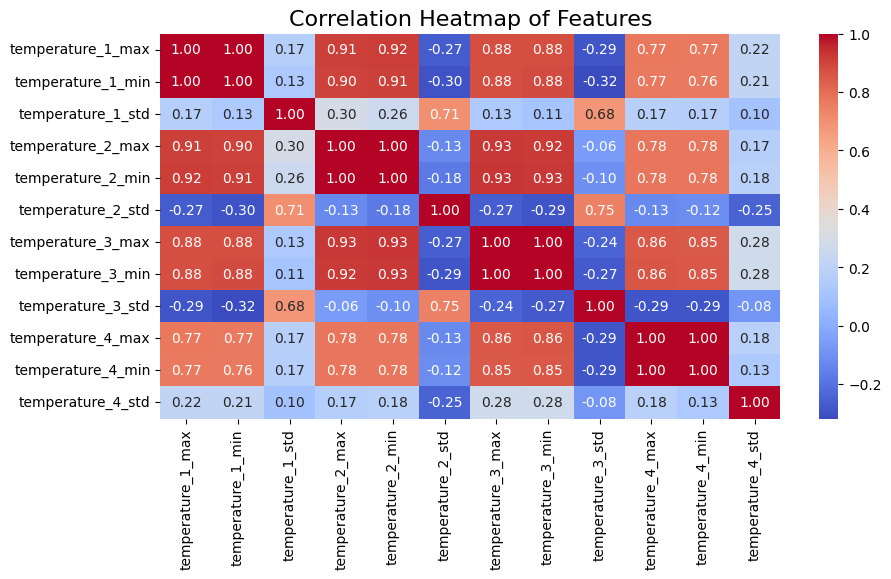

In [13]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(features, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix, index=feature_column, columns=feature_column)

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

In [14]:
# Apply PCA to retain 99% of the variance in the data
pca = PCA(0.99)
pca_features = pca.fit_transform(features)

##### PCA reduces the dimension as well as retains the most prominent patterns in the data

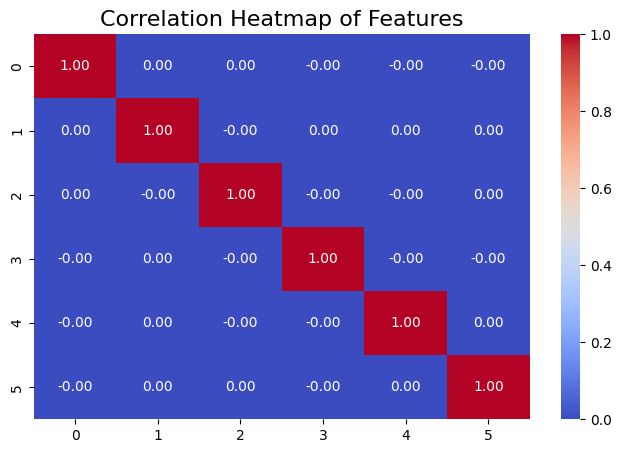

In [15]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(pca_features, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix)

# Plot heatmap using Seaborn
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

Thus the above twelve features have been reduced to six features which can give better result

## Model Training and Evaluation



In [16]:
X_train, X_test, y_train, y_test = train_test_split(pca_features, label, test_size=0.3, random_state=42)

In [17]:
smote = SMOTE(random_state=42)
# Resample the training data to balance classes
X_train, y_train = smote.fit_resample(X_train, y_train)

In [18]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=1000,
    per_run_time_limit=300,
    memory_limit=8192,
    metric=autosklearn.metrics.f1,
    # ensemble_size=50,  # Allow a larger ensemble
    # ensemble_nbest=10  # Use the best 10 models in ensemble
)



In [19]:
automl.fit(X_train, y_train)
automl.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
2,1,0.84,random_forest,0.010355,145.470994,1,0.000000,0,1.739223e+09,1.739223e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
10,2,0.02,random_forest,0.022386,101.606992,9,0.004640,0,1.739224e+09,1.739224e+09,0.0,StatusType.SUCCESS,[],[select_rates_classification],none,Initial design
8,3,0.08,mlp,0.240813,287.457248,7,0.233661,0,1.739224e+09,1.739224e+09,0.0,StatusType.SUCCESS,[],[pca],none,Initial design
9,4,0.06,sgd,0.479752,2.852756,8,0.472376,0,1.739224e+09,1.739224e+09,0.0,StatusType.SUCCESS,[],[select_percentile_classification],none,Initial design


In [20]:
# Make predictions
y_pred = automl.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy: {f1score:.2f}')

Accuracy: 0.98
Accuracy: 0.82


In [21]:
outlier_removed_features, outlier_removed_label = feature_extraction(outlier_removed_df)

In [22]:
outlier_removed_features = outlier_removed_features.drop(['part_id', 'window_start', 'window_end'], axis=1)
scaler = MinMaxScaler()
outlier_removed_features = scaler.fit_transform(outlier_removed_features)

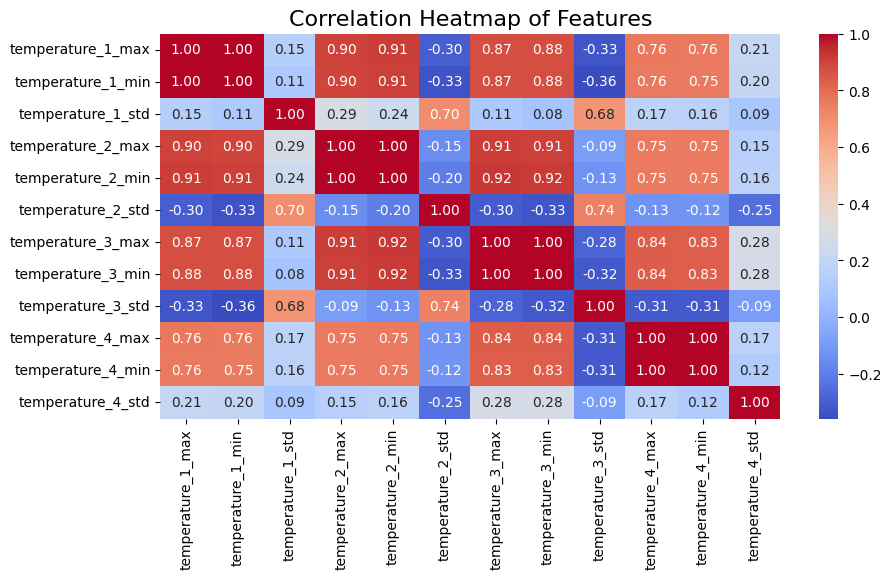

In [23]:
# Calculate correlation matrix
correlation_matrix = np.corrcoef(outlier_removed_features, rowvar=False)
correlation_df = pd.DataFrame(correlation_matrix, index=feature_column, columns=feature_column)

# Plot heatmap using Seaborn
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Features", fontsize=16)
plt.show()

In [24]:
pca = PCA(0.99)
outlier_removed_pca_features = pca.fit_transform(outlier_removed_features)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(outlier_removed_pca_features, outlier_removed_label, test_size=0.3, random_state=42)

In [26]:
smote = SMOTE(random_state=42)
# Resample the training data to balance classes
X_train, y_train = smote.fit_resample(X_train, y_train)

In [27]:
automl = autosklearn.classification.AutoSklearnClassifier(
                time_left_for_this_task=1000,
                per_run_time_limit=300,
                memory_limit=8192,
                metric=autosklearn.metrics.f1,
                # ensemble_size=50,  # Allow a larger ensemble
                # ensemble_nbest=10  # Use the best 10 models in ensemble
            )

In [28]:
automl.fit(X_train, y_train)
automl.leaderboard(detailed=True)

,rank,ensemble_weight,type,cost,duration,config_id,train_loss,seed,start_time,end_time,budget,status,data_preprocessors,feature_preprocessors,balancing_strategy,config_origin
model_id,,,,,,,,,,,,,,,,
2,1,0.62,random_forest,0.010084,137.021129,1,0.000000,0,1.739224e+09,1.739224e+09,0.0,StatusType.SUCCESS,[],[no_preprocessing],none,Initial design
9,2,0.02,random_forest,0.016688,97.993224,8,0.003332,0,1.739225e+09,1.739225e+09,0.0,StatusType.SUCCESS,[],[select_rates_classification],none,Initial design
8,3,0.12,mlp,0.177428,271.619894,7,0.170869,0,1.739225e+09,1.739225e+09,0.0,StatusType.SUCCESS,[],[pca],none,Initial design
10,4,0.24,sgd,0.453155,2.726488,9,0.454821,0,1.739225e+09,1.739225e+09,0.0,StatusType.SUCCESS,[],[select_percentile_classification],none,Initial design


In [29]:
# Make predictions
y_pred = automl.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
f1score = f1_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy: {f1score:.2f}')

Accuracy: 0.98
Accuracy: 0.82
